In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


In [2]:
tf.random.set_seed(1234)

In [3]:
NOISE_DIM = 128 # 64 in Gitlab
TESTING= False
BATCH_SIZE = 64
SAMPLE_SIZE= 50000
BINS = 25

np_bg_SB = np.load('./data/processed/np_bg_SB_1.npy')
np_bg_SB= np_bg_SB[:,[0,1,2,3,4,5,6,7,8,11]]
test_data = np.load('./data/test_data_1.npy')
train_sig = np.load('./data/train_signal_1.npy')
train_background = np.load('./data/train_background_1.npy')
np_combined_SR_labeled = np.concatenate((train_sig, train_background), axis = 0)
gc.collect()

12

In [4]:
sb = pd.DataFrame(np_bg_SB,columns = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj'])
sb

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj
0,1260.051636,0.422217,389.532013,622.454224,-1.856698,2.962399,22.999201,0.519086,0.787733,3107.620605
1,1255.513428,1.118943,55.797798,1244.178467,-0.326108,3.081639,359.113007,0.277957,0.590729,3233.075195
2,1567.896484,-0.666511,47.442600,1362.592896,-0.015116,3.094602,286.755005,0.488864,0.447114,3111.458496
3,1260.839600,-0.803750,478.921997,1129.338989,0.734482,3.122360,35.523300,0.429055,0.789323,3195.022705
4,1527.768188,0.584197,311.196991,1355.966553,1.416072,2.941976,114.981003,0.518980,0.821918,3162.099609
...,...,...,...,...,...,...,...,...,...,...
260141,1662.803223,-0.038826,84.837196,1444.321777,0.299155,3.184224,191.481003,0.434714,0.182728,3157.497070
260142,1584.508911,-0.455755,276.209991,1526.918213,-0.307391,3.100913,120.094002,0.437816,0.843754,3146.891602
260143,1500.259399,0.886107,146.237000,1213.367798,-0.822252,3.133430,225.348999,0.590159,0.572788,3764.679199
260144,1221.397339,1.198329,74.893898,1131.393311,-0.893655,3.104052,322.371002,0.677300,0.215650,3792.294189


In [5]:
train_sig.shape

(75502, 11)

In [6]:
np_combined_SR_labeled.shape

(196636, 11)

In [7]:
def cut_data(uncut_data, pTmin = 1200, etamax = 2.5):
    # Column 0: ptj1
    # Column 1: etaj1
    # Column 3: ptj2
    # Column 4: etaj2
    return uncut_data[((uncut_data[:,0] > pTmin) & (np.abs(uncut_data[:,1]) < etamax)) | ((uncut_data[:,3] > pTmin) & (np.abs(uncut_data[:,4]) < etamax))]

def generate_gan(generator, realdata):

    labels = sample_fake(refdata = realdata, size = SAMPLE_SIZE) # Sample mjj from the existing distribution of mjj for comparison
    labels_scaled = scaler_mjj.transform(labels.reshape(-1,1))
    fakedata_uncut_unscaled = generator(tf.concat([tf.random.uniform((SAMPLE_SIZE, NOISE_DIM)), labels_scaled], 1), training=False)
    fakedata_uncut = np.concatenate((scaler.inverse_transform(fakedata_uncut_unscaled), labels.reshape(-1,1)), axis = 1)

    # At least one jet has pT > 1200 and |eta| < 2.5
    fakedata = cut_data(fakedata_uncut)
    # mjj = sqrt(Ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
    fakedata_mjj = mjj(fakedata)
    return fakedata
def mjj(output):
    pt1 = output[:,0]
    eta1 = output[:,1]
    m1 = output[:,2]
    pt2 = output[:,3]
    eta2 = output[:,4]
    phi2 = output[:,5]
    m2 = output[:,6]
    ejj = np.sqrt((pt1 * np.cosh(eta1))**2 + m1**2) + np.sqrt((pt2 * np.cosh(eta2))**2 + m2**2)
    pxjj = pt1 + pt2 * np.cos(phi2)
    pyjj = pt2 * np.sin(phi2)
    pzjj = pt1 * np.sinh(eta1) + pt2 * np.sinh(eta2)
    return np.sqrt(ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
def sample_fake(refdata = np_combined_SR_labeled, size = BATCH_SIZE):
    rand_idx = np.random.choice(refdata.shape[0], size = size)
    return refdata[rand_idx, -1].reshape((-1,1))
def sample_data(refdata = np_combined_SR_labeled,size= 10000):
    rand_idx = np.random.choice(refdata.shape[0], size)
    return refdata[rand_idx, :]
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      
]
def classifier_model():    
    model = tf.keras.Sequential()
    model.add(layers.Dense(64,input_dim = 4,activation ='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[METRICS])
    return model

def learningCurveLoss(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    #plt.ylim(0,5)
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('5_tag_learning_curve.png')
    plt.show()
    plt.close()
    #plt.savefig("Learning_Curve")
def plot_roc_curve(y_test, y_test_score):

    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    auc_value = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    plt.show()




In [8]:

np_bg_SB_trimmed = np.delete(np_bg_SB, [i for i in range(np_bg_SB.shape[0] % (BATCH_SIZE * 4))], axis = 0)

# Normalize inputs between -1 and 1, mjj between 0 and 1
scaler = MinMaxScaler((-1,1)).fit(np_bg_SB_trimmed[:,:-1])
scaler_mjj = MinMaxScaler((0,1)).fit(np_bg_SB_trimmed[:,-1].reshape(-1,1))
np_bg_SB_scaled = np.concatenate((scaler.transform(np_bg_SB_trimmed[:,:-1]), scaler_mjj.transform(np_bg_SB_trimmed[:,-1].reshape(-1,1))), axis = 1)

In [9]:
gen_model = tf.keras.models.load_model('./Results/epoch500-generator.h5')

In [10]:
sig_SR = sample_data(train_sig,1000)
bg_SR = sample_data(train_background,1000)
sampleA = np.concatenate((sig_SR,bg_SR),axis=0) #real data
sampleA = np.concatenate((sampleA,np.ones([len(sampleA),1])),axis=1) #put label 1 for real

generated_data = generate_gan(gen_model,np_combined_SR_labeled[:,0:10])
generated_data2 = generate_gan(gen_model,np_combined_SR_labeled[:,0:10])
generated_data = np.concatenate((generated_data,generated_data2), axis = 0)
generated_data_labeled  = np.copy(generated_data)
generated_data_labeled = np.append(generated_data_labeled,np.zeros([len(generated_data_labeled),1]),1)

sampleB= sample_data(generated_data_labeled,2000) # generated data
sampleB = np.concatenate((sampleB,np.zeros([len(sampleB),1])),axis=1)

In [11]:
var = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sb']
def plot_gen(a,b,j):
    fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 50))
    for i in range(0,10):
        
        axes[i].hist(a[:,i],25,alpha=0.6,histtype = 'step',label = 'data',density = True)

        #plt.hist(np_sig_SB[:,i],25,alpha = 0.6,histtype = 'step',label = 'signal',density = True)
        axes[i].hist(b[:,i],25,alpha = 0.6,histtype = 'step',label = 'generated',density = True)
        axes[i].set_title(var[i])

    plt.legend()
    plt.savefig('./Results/Classifier/PlotsSB2/plots_'+j)
    plt.close(fig)  


In [12]:
sig_SR = sample_data(train_sig,10)
bg_SR = sample_data(train_background,10)
sampleA = np.concatenate((sig_SR,bg_SR),axis=0) #real data
sampleA = np.concatenate((sampleA,np.ones([len(sampleA),1])),axis=1) #adding real fake label to real dat


In [13]:
gdf = pd.DataFrame(sampleA, columns = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sb','rf'])
gdf

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj,sb,rf
0,1497.446777,-0.541349,88.550201,1357.025879,0.830874,3.115863,86.314697,0.575056,0.418098,3552.940674,1.0,1.0
1,1610.064453,-0.521177,489.531006,1476.281250,0.168384,3.143287,108.212997,0.272943,0.269953,3337.934326,1.0,1.0
2,1701.143799,0.424603,103.861000,1648.705322,0.699937,3.161908,494.276001,0.122915,0.283135,3451.835938,1.0,1.0
3,1433.045044,1.387027,480.825989,1422.953369,0.009726,3.154323,254.264999,0.241560,0.585434,3635.680420,1.0,1.0
4,1755.026489,-0.361438,135.182999,1182.394531,0.930026,2.775636,498.442993,0.520220,0.562900,3541.577393,1.0,1.0
5,1526.952881,-0.035577,115.862999,1509.336670,-0.955169,3.129956,496.167999,0.205438,0.236759,3428.346924,1.0,1.0
6,1668.206665,-0.291245,456.234009,1629.334595,0.121838,3.175909,142.063995,0.140405,0.388519,3432.646240,1.0,1.0
7,1460.574585,1.363054,108.706001,1321.777710,0.224921,3.205866,371.699005,0.693412,0.524442,3310.084717,1.0,1.0
8,1545.634399,-0.752381,498.647003,1453.242798,0.281006,3.135839,106.892998,0.125043,0.328201,3473.450439,1.0,1.0
9,1708.205444,0.000327,522.385986,1550.128540,0.149408,3.155335,89.956398,0.142515,0.315889,3344.430176,1.0,1.0


In [23]:
def train_generated(s,b,iteration,ratio):
    
    fpr_list = []
    tpr_list = []
    auc_list = []
    
    #generate fake background data and add signal background labels
    generated_data = generate_gan(gen_model,np_combined_SR_labeled[:,0:10])
    generated_data2 = generate_gan(gen_model,np_combined_SR_labeled[:,0:10])
    generated_data = np.concatenate((generated_data,generated_data2), axis = 0)
    generated_data_labeled  = np.copy(generated_data)
    generated_data_labeled = np.append(generated_data_labeled,np.zeros([len(generated_data_labeled),1]),1) 
    
    
    # sample a certain s/b ratio in SR from data and add real fake label
    sig_SR = sample_data(train_sig,s)
    bg_SR = sample_data(train_background,b)
    sampleA = np.concatenate((sig_SR,bg_SR),axis=0) #real data
    sampleA = np.concatenate((sampleA,np.ones([len(sampleA),1])),axis=1) #adding real fake label to real data


    # sample s+b fake background and add real fake label
    sampleB= sample_data(generated_data_labeled,s+b) # generated data
    sampleB = np.concatenate((sampleB,np.zeros([len(sampleB),1])),axis=1) #adding real fake label to fake background
    
    #plot_gen(sampleA,sampleB,"Mixed_vs_Generated"+str(iteration))
    #plot_gen(sig_SR,sampleB,"sig_vs_fake"+str(iteration))
    #plot_gen(bg_SR,sampleB,"bg_vs_fake" + str(iteration))
    
    dataset = np.concatenate((sampleA,sampleB),axis=0) #dataset to traintest split
    x_train,x_val,y_train,y_val= train_test_split(dataset[:,[2,6,7,8]],dataset[:,-1], test_size = 0.2, random_state=1) #rf label
    x_test,y_test = test_data[:,[2,6,7,8]],test_data[:,-1] #sb label
    
    classifier = classifier_model()
    es = EarlyStopping(monitor='val_loss',min_delta = 1e-3, mode='min', verbose=1, patience=5)
    history = classifier.fit(x_train, y_train, epochs=50, batch_size=256,validation_data=(x_val,y_val),callbacks=[es], verbose = 1)
    learningCurveLoss(history)
    y_pred = classifier.predict(x_test) #predict on signal vs background in test sample
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = auc(fpr,tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    auc_list.append(auc_value)
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')
    print(auc_value)
    print(auc_list)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    np.save('./Results/Classifier/generated/tpr/'+str(ratio)+'/tpr_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(tpr_list),allow_pickle = True)
    np.save('./Results/Classifier/generated/fpr/'+str(ratio)+'/fpr_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(fpr_list),allow_pickle = True)
    np.save('./Results/Classifier/generated/auc/'+str(ratio)+'/auc_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(auc_list),allow_pickle = True)
    

In [24]:
sb_ratio = [0.001 , 0.00215443, 0.00464159,0.01, 0.02154435, 0.04641589, 0.1 , 0.21544347  ,0.46415888 , 1.]

In [ ]:
for i in sb_ratio:
    if(i == 1.0):
        signal = 50000
        bg = 50000
    else:
        signal = (np.round(i * 100000))
        bg = (np.round((1 - i) * 100000))
    for j in range(5):
        train_generated(signal.astype(int),bg.astype(int),j,i)
        

In [18]:

def train_sb(s,b,iteration,ratio):
        
    fpr_sb = []
    tpr_sb = []
    auc_sb = []

    # sample a certain s/b ratio in SR from data and add real fake label
    sig_SR = sample_data(train_sig,s)
    bg_SR = sample_data(train_background,b)
    bg_SR2 =sample_data(train_background,s+b)

    
    dataset = np.concatenate((sig_SR ,bg_SR),axis=0) #dataset to traintest split
    x_train,x_val,y_train,y_val= train_test_split(dataset[:,[2,6,7,8]],dataset[:,-1], test_size = 0.2, random_state=1) 
    x_test,y_test = test_data[:,[2,6,7,8]],test_data[:,-1] #sb label
    
    classifier = classifier_model()
    es = EarlyStopping(monitor='val_loss',min_delta = 1e-3, mode='min', verbose=1, patience=5)
    history = classifier.fit(x_train, y_train, epochs=25, batch_size=256,validation_data=(x_val,y_val),callbacks=[es], verbose = 1)
    learningCurveLoss(history)
    y_pred = classifier.predict(x_test) #predict on signal vs background in test sample
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = auc(fpr,tpr)
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    fpr_sb.append(fpr)
    tpr_sb.append(tpr)
    auc_sb.append(auc_value)
    np.save('./Results/Classifier/sbvsb/tpr/'+str(ratio)+'/tpr_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(tpr_sb),allow_pickle = True)
    np.save('./Results/Classifier/sbvsb/fpr/'+str(ratio)+'/fpr_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(fpr_sb),allow_pickle = True)
    np.save('./Results/Classifier/sbvsb/auc/'+str(ratio)+'/auc_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(auc_sb),allow_pickle = True)
    

In [ ]:
for i in sb_ratio:
    if(i == 1.0):
        signal = 50000
        bg = 50000
    else:
        signal = (np.round(i * 100000))
        bg = (np.round((1 - i) * 100000))

    for j in range(5):
        train_sb(signal.astype(int),bg.astype(int),j,i)
        

In [130]:
def train_optimal():
    auc_list = []
    tpr_list = []
    fpr_list = []


    x_train,x_val,y_train,y_val = train_test_split(np_combined_SR_labeled[:,[2,6,7,8]],np_combined_SR_labeled[:,-1], test_size = 0.2, random_state=4) #sb label
    x_test,y_test = test_data[:,[2,6,7,8]],test_data[:,-1]
    classifier = classifier_model()
    es = EarlyStopping(monitor='val_loss',min_delta = 1e-3, mode='min', verbose=1, patience=5)
    history = classifier.fit(x_train, y_train, epochs=50, batch_size=512,validation_data=(x_val,y_val),callbacks=[es], verbose = 1)
    learningCurveLoss(history)

    y_pred = classifier.predict(x_test) 
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = auc(fpr,tpr)
    auc_list.append(auc_value)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')
    print(auc_value)
    print(auc_list)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    #np.save('./Results/Classifier/optimal/tpr/'+str(ratio)+'/tpr_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(tpr_sb),allow_pickle = True)
    #np.save('./Results/Classifier/optimal/fpr/'+str(ratio)+'/fpr_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(fpr_sb),allow_pickle = True)
    #np.save('./Results/Classifier/optimal/auc/'+str(ratio)+'/auc_list_' + str(iteration) + '_' + str(ratio) + '.npy',np.asarray(auc_sb),allow_pickle = True)

Train on 157308 samples, validate on 39328 samples
Epoch 1/50
157308/157308 [==============================] - 3s 19us/sample - loss: 1.1543 - tp: 36786.0000 - fp: 29812.0000 - tn: 67079.0000 - fn: 23631.0000 - accuracy: 0.6603 - precision: 0.5524 - recall: 0.6089 - auc: 0.6684 - val_loss: 0.5518 - val_tp: 13210.0000 - val_fp: 7797.0000 - val_tn: 16446.0000 - val_fn: 1875.0000 - val_accuracy: 0.7541 - val_precision: 0.6288 - val_recall: 0.8757 - val_auc: 0.8364
Epoch 2/50
157308/157308 [==============================] - 1s 7us/sample - loss: 0.5630 - tp: 43211.0000 - fp: 22477.0000 - tn: 74414.0000 - fn: 17206.0000 - accuracy: 0.7477 - precision: 0.6578 - recall: 0.7152 - auc: 0.7887 - val_loss: 0.4804 - val_tp: 12267.0000 - val_fp: 3940.0000 - val_tn: 20303.0000 - val_fn: 2818.0000 - val_accuracy: 0.8282 - val_precision: 0.7569 - val_recall: 0.8132 - val_auc: 0.8542
Epoch 3/50
157308/157308 [==============================] - 1s 7us/sample - loss: 0.4956 - tp: 44456.0000 - fp: 16484.00

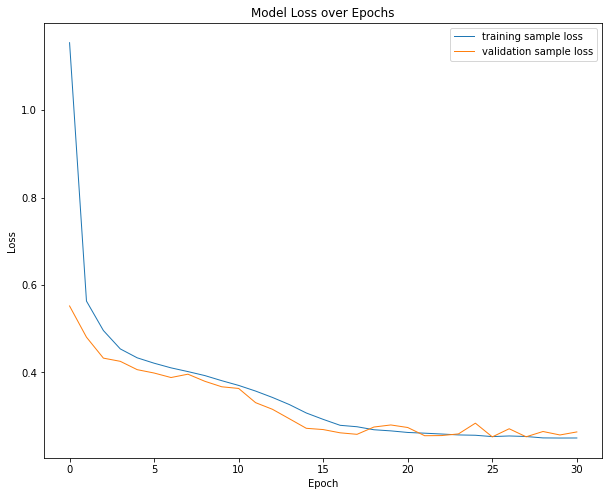

0.9540258370408201
[0.9540258370408201]


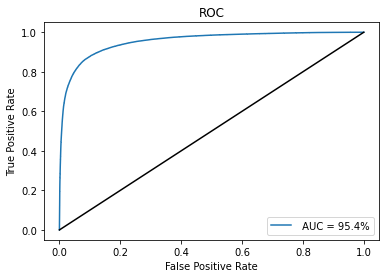

In [131]:
train_optimal()